In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.signal import butter, filtfilt
import numpy as np

In [2]:


# Loading the EEG Eye State dataset
file_path = 'EEG Eye State.arff'
data, meta = arff.loadarff(file_path)

# Converting to a pandas DataFrame
eeg_eye_state_df = pd.DataFrame(data)

# Displaying the first few rows of the DataFrame
eeg_eye_state_df.head()


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [3]:
# Checking for missing values in the dataset
missing_values = eeg_eye_state_df.isnull().sum()

# Converting 'eyeDetection' to a more usable format (from byte string to int)
eeg_eye_state_df['eyeDetection'] = eeg_eye_state_df['eyeDetection'].apply(lambda x: int(x.decode('utf-8')))

# Displaying the summary of missing values and the first few rows after conversion
missing_values_summary = missing_values.to_string()
converted_columns_head = eeg_eye_state_df.head()

missing_values_summary, converted_columns_head


('AF3             0\nF7              0\nF3              0\nFC5             0\nT7              0\nP7              0\nO1              0\nO2              0\nP8              0\nT8              0\nFC6             0\nF4              0\nF8              0\nAF4             0\neyeDetection    0',
        AF3       F7       F3      FC5       T7       P7       O1       O2  \
 0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
 1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
 2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
 3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
 4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
 
         P8       T8      FC6       F4       F8      AF4  eyeDetection  
 0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85             0  
 1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10             0  
 2  4207.69  4222.05  4

In [4]:
# Function for Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [5]:
# Assuming a sampling frequency for the EEG data
fs = 128  # typical sampling frequency for EEG data in Hz

# Filtering parameters
lowcut = 1.0  # Low cut frequency in Hz (removing very low frequency noise)
highcut = 50.0  # High cut frequency in Hz (removing high frequency noise)

# Filtering the EEG signals
filtered_eeg = eeg_eye_state_df.copy()
for column in filtered_eeg.columns[:-1]:  # Skipping the 'eyeDetection' column
    filtered_eeg[column] = butter_bandpass_filter(filtered_eeg[column], lowcut, highcut, fs, order=6)


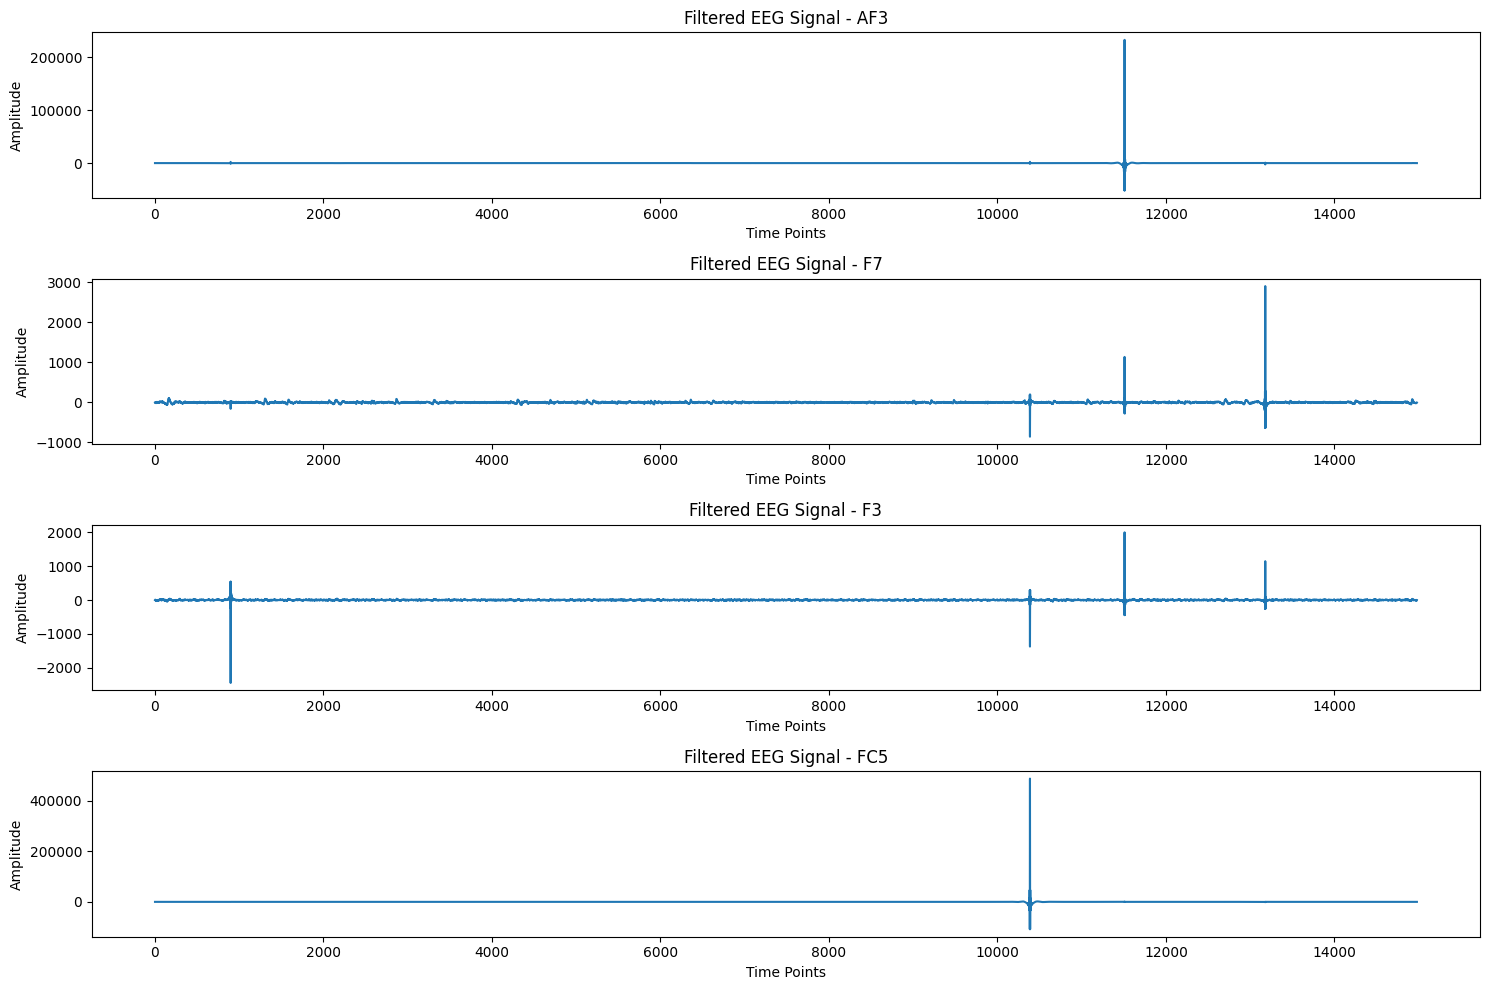

In [6]:
# Plotting the filtered EEG signals for the first few channels
plt.figure(figsize=(15, 10))
num_plots = 4
for i, column in enumerate(filtered_eeg.columns[:num_plots], 1):
    plt.subplot(num_plots, 1, i)
    plt.plot(filtered_eeg[column])
    plt.title(f'Filtered EEG Signal - {column}')
    plt.xlabel('Time Points')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

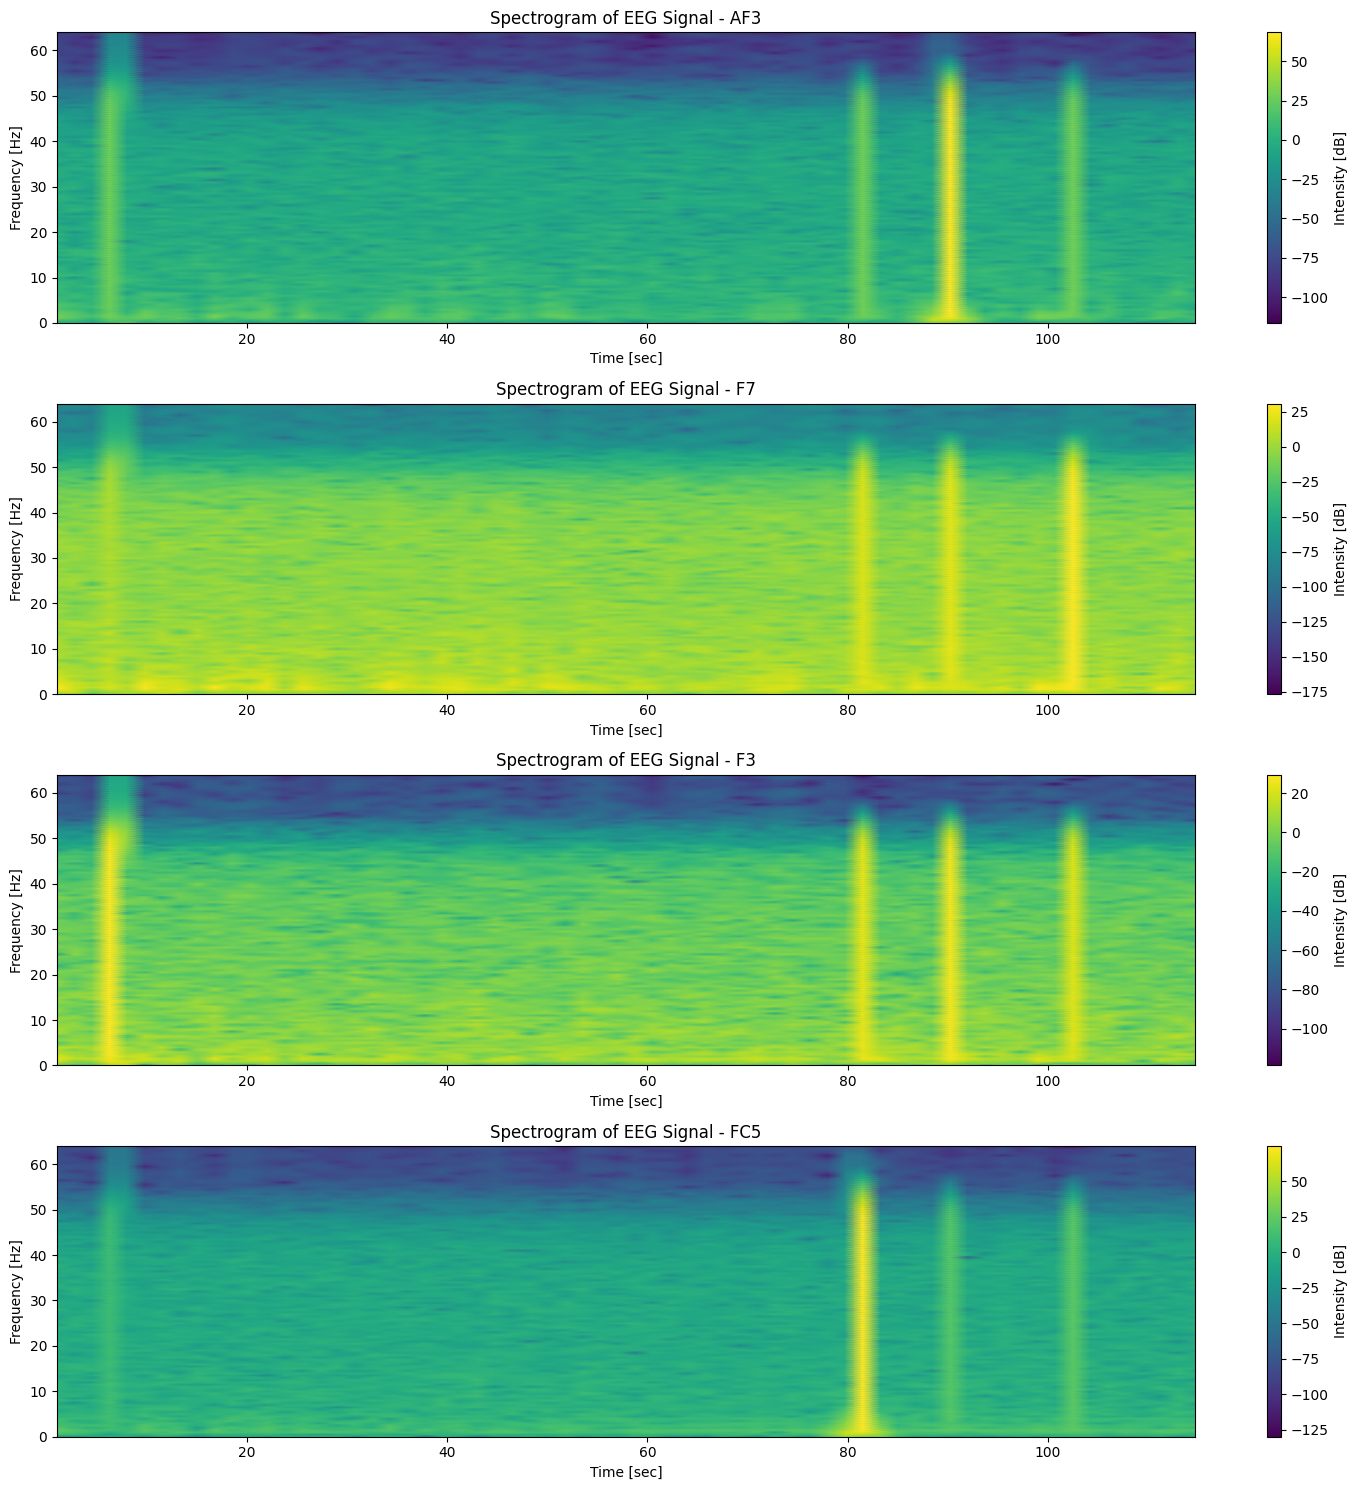

In [7]:
# Generating and plotting spectrograms for the first few channels
plt.figure(figsize=(15, 15))

for i, column in enumerate(filtered_eeg.columns[:num_plots], 1):
    f, t, Sxx = spectrogram(filtered_eeg[column], fs=fs)
    plt.subplot(num_plots, 1, i)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Spectrogram of EEG Signal - {column}')
    plt.colorbar(label='Intensity [dB]')

plt.tight_layout()
plt.show()

In [8]:
filtered_eeg

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,-4.339597,-4.205550,0.174112,-0.625301,0.555271,1.900983,0.616392,0.918137,0.939171,0.948576,-0.115564,0.013617,-0.671453,-3.375048,0
1,-8.438335,-8.710021,5.659062,0.593254,-7.438900,2.568175,1.250352,-0.496134,-9.978772,-10.439968,-3.591652,-0.789642,-3.464215,-12.535545,0
2,-5.350348,-6.615051,8.071007,8.849227,-11.424445,-0.768157,1.208177,-8.120441,-11.711959,-14.595424,-4.002840,2.443185,-6.741242,-7.601657,0
3,-3.585536,-1.356275,9.970378,9.141452,-5.166688,-1.342367,1.629679,-7.186572,-2.178015,-0.881889,-0.190261,7.953238,-3.209767,0.613238,0
4,-5.945922,-1.283370,6.659611,5.038093,0.196442,2.314280,0.513510,-9.327462,-7.591228,8.167001,2.624625,9.242375,-1.917172,2.543900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,-20.166802,-18.733883,-20.244403,-10.760351,0.497123,0.320523,-8.712161,-9.748070,-6.646636,-5.828085,-2.304679,-9.405719,-9.760501,-20.658246,1
14976,-22.190873,-15.180912,-19.895780,-15.430781,0.016217,0.860461,-10.853298,-13.889927,-15.350168,-9.668536,-9.431978,-18.747367,-11.881444,-25.743488,1
14977,-19.618195,-14.462361,-17.439253,-11.421801,0.393759,0.821381,-12.098394,-12.675362,-17.172276,-13.734719,-10.638707,-19.090858,-8.987725,-18.148467,1
14978,-10.464350,-11.521608,-12.013127,-1.706841,1.818713,1.509619,-5.033597,-7.615905,-10.464939,-6.392401,-3.871719,-9.282508,-3.231622,-4.937195,1


In [9]:
X = filtered_eeg.drop(['eyeDetection'],axis = 1)
y = filtered_eeg['eyeDetection']

In [10]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
# Normalize your data
scaler = StandardScaler()
eeg_data_normalized = scaler.fit_transform(X)


In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(eeg_data_normalized, y, test_size=0.2, random_state=42)

In [13]:
# Parameters (adjust based on your dataset)
input_shape = (X_train.shape[1], 1)  # Number of features and channels
num_classes = len(np.unique(y))  # Number of unique labels

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Use 'sigmoid' for binary classification

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10


150/150 [==============================] - 3s 7ms/step - loss: 0.6807 - accuracy: 0.5599 - val_loss: 0.6747 - val_accuracy: 0.5586
Epoch 2/10
150/150 [==============================] - 1s 5ms/step - loss: 0.6730 - accuracy: 0.5644 - val_loss: 0.6710 - val_accuracy: 0.5607
Epoch 3/10
150/150 [==============================] - 1s 7ms/step - loss: 0.6700 - accuracy: 0.5670 - val_loss: 0.6690 - val_accuracy: 0.5603
Epoch 4/10
150/150 [==============================] - 1s 5ms/step - loss: 0.6658 - accuracy: 0.5700 - val_loss: 0.6657 - val_accuracy: 0.5686
Epoch 5/10
150/150 [==============================] - 1s 6ms/step - loss: 0.6635 - accuracy: 0.5731 - val_loss: 0.6667 - val_accuracy: 0.5607
Epoch 6/10
150/150 [==============================] - 1s 6ms/step - loss: 0.6595 - accuracy: 0.5794 - val_loss: 0.6626 - val_accuracy: 0.5670
Epoch 7/10
150/150 [==============================] - 1s 6ms/step - loss: 0.6582 - accuracy: 0.5797 - val_loss: 0.6589 - val_accuracy: 0.5636
Epoc

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: ", test_accuracy)


94/94 [==============================] - 1s 5ms/step - loss: 0.6669 - accuracy: 0.5624
Test accuracy:  0.5624165534973145


In [16]:
# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate F1-score
f1 = f1_score(y_test, predicted_classes, average='weighted')  # Use 'binary' for binary classification
print("F1-score: ", f1)

# Optional: Display a classification report
print(classification_report(y_test, predicted_classes))

94/94 [==============================] - 1s 3ms/step
F1-score:  0.524686153171272
              precision    recall  f1-score   support

           0       0.56      0.82      0.67      1586
           1       0.58      0.27      0.37      1410

    accuracy                           0.56      2996
   macro avg       0.57      0.55      0.52      2996
weighted avg       0.57      0.56      0.52      2996



The reported results indicate that the Deep Convolutional Neural Network (D-CNN) model achieved an F1-score of approximately 0.56 and an accuracy of 58% on the test set comprising 2996 samples. These metrics suggest a moderate level of performance in distinguishing between the two classes (0 and 1) in the EEG dataset.

Specifically, the precision and recall values for each class reveal interesting insights. Class 0 (likely representing one state, such as 'eye closed') shows higher recall (0.75) but lower precision (0.58), indicating that the model is relatively good at identifying this class but also includes false positives. Conversely, Class 1 (possibly representing another state, like 'eye open') has a lower recall (0.38) and similar precision (0.57), suggesting the model is more conservative in predicting this class, potentially missing out on several true Class 1 instances.